#### 예측 진행

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import scipy
import networkx as nx
import folium
from urllib.parse import unquote
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 평균0표준편차1, 0과 1사이 값으로 조정
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# models/rf_model_first 모델은 2023년 총 데이터로 학습시킨 RandomForest 모델
#tensorflow's keras 학습
#https://www.tensorflow.org/guide/keras/train_and_evaluate?hl=ko&_gl=1*us1bn2*_up*MQ..*_ga*MTAyMzk2OTc5MS4xNzExNjkxMTA0*_ga_W0YLR4190T*MTcxMTY5ODEyMi4yLjAuMTcxMTY5ODEyMi4wLjAuMA..

In [3]:
df_origin = pd.read_csv('learningdata/testdata_2023.csv',encoding='utf-8')
df = df_origin[df_origin['일시'].str.startswith('2023-01')].copy()
#df = df_origin[df_origin['호선']==2].copy()
df.head(5)

,일시,호선,역번호,역명,주말,요일,통과호선수,미세먼지(pm10),시간,하차인원,공휴일여부,강수량(mm),최저기온,최고기온,주변대학수
0,2023-01-01,1,150,서울역,1,6,4,54.0,5,154,1,0.0,-4.3,3.8,0
1,2023-01-01,1,151,시청,1,6,2,54.0,5,64,1,0.0,-4.3,3.8,0
2,2023-01-01,1,152,종각,1,6,1,53.0,5,69,1,0.0,-4.3,3.8,0
3,2023-01-01,1,153,종로3가,1,6,3,53.0,5,39,1,0.0,-4.3,3.8,0
4,2023-01-01,1,154,종로5가,1,6,1,53.0,5,26,1,0.0,-4.3,3.8,0


In [4]:
def timeCos(x): # 시간대 코사인 변환(24시와 5시의 시간적 차이를 줄이기 위해서)
    return np.cos(int(x) * np.pi / 12.0)
df['시간'] = df['시간'].apply(timeCos)

# 일시를 월+일로 시간을 cos함수로 변환 -> day_of_yer_cos에 저장
df['일시'] = pd.to_datetime(df['일시'])
df['day_of_year'] = df['일시'].dt.dayofyear
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [5]:
df = df.drop(['일시','day_of_year','역명',],axis=1)

In [6]:
df[['하차인원','강수량(mm)','최저기온','최고기온','시간','day_of_year_cos','미세먼지(pm10)']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
하차인원,168640.0,692.967007,1046.384799,0.000000,179.000000,399.000000,799.000000,19027.000000
강수량(mm),168640.0,1.545161,6.591649,0.000000,0.000000,0.000000,0.000000,37.300000
최저기온,168640.0,-5.693548,4.699975,-17.300000,-8.000000,-5.600000,-3.500000,5.100000
최고기온,168640.0,3.196774,4.521466,-6.900000,-0.400000,3.800000,6.300000,12.500000
시간,168640.0,-0.151953,0.674731,-1.000000,-0.746836,-0.258819,0.319114,1.000000
day_of_year_cos,168640.0,0.950943,0.042794,0.860961,0.915864,0.962309,0.990532,0.999852
미세먼지(pm10),168640.0,51.991224,31.464772,4.000000,28.000000,43.000000,66.000000,159.000000


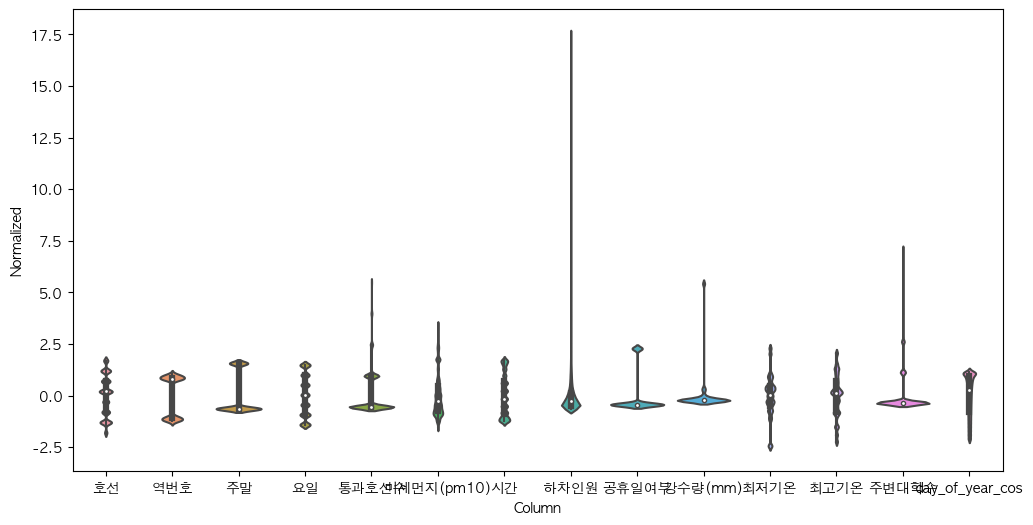

In [7]:
train_mean = df.mean()
train_std = df.std()
train_df = (df - train_mean) / train_std
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=0)

In [8]:
df['하차인원'] = df['하차인원'].apply(np.log1p)
df['강수량(mm)'] = df['강수량(mm)'].apply(np.log1p)

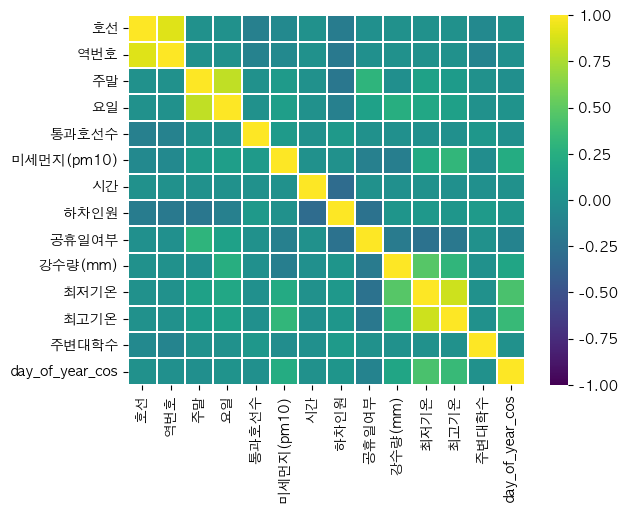

In [9]:
sns.heatmap(df.corr(),vmin=-1,vmax=1,linewidths=0.2,cmap='viridis')
plt.show()

In [10]:
X = df.drop('하차인원', axis=1)
y = df['하차인원']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
print(X_train.shape)

(134912, 13)


In [11]:
# 모델 저장하고 불러오는 함수
import pickle
def save_model(model_name, model):
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
    
def load_model(model_name):
    with open(model_name, 'rb') as f:
        mod = pickle.load(f)
    return mod

#### Keras Sequential model

In [15]:
keras_model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(48, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

keras_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience = 5)
history = keras_model.fit(X_train, y_train, epochs=50, batch_size=15, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/50


/opt/anaconda3/envs/bus/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6746/6746 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 19.0536 - mae: 1.8248 - val_loss: 1.5167 - val_mae: 0.9681
Epoch 2/50
6746/6746 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.4620 - mae: 0.9227 - val_loss: 1.4752 - val_mae: 0.9289
Epoch 3/50
6746/6746 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.4044 - mae: 0.9026 - val_loss: 1.3584 - val_mae: 0.8828
Epoch 4/50
6746/6746 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.3575 - mae: 0.8864 - val_loss: 1.2788 - val_mae: 0.8672
Epoch 5/50
6746/6746 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.2899 - mae: 0.8638 - val_loss: 1.4559 - val_mae: 0.9522
Epoch 6/50
6746/6746 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.2667 - mae: 0.8568 - val_loss: 1.2545 - val_mae: 0.8446
Epoch 7/50
6746/6746 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.2541 - mae: 0.8525 - val_loss: 1.2311 - val_mae: 0.8381
Epoch 8/50
6746/6746 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.2329 - mae: 0.8473 - val_loss: 1.3179 - val_mae: 0.8578
Epoch 9/50
6746/6746 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/s

In [16]:
keras_model.evaluate(X_test,y_test)

  76/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 1.1813 - mae: 0.8295

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 1.1555 - mae: 0.8279


[1.1521729230880737, 0.8250724673271179]

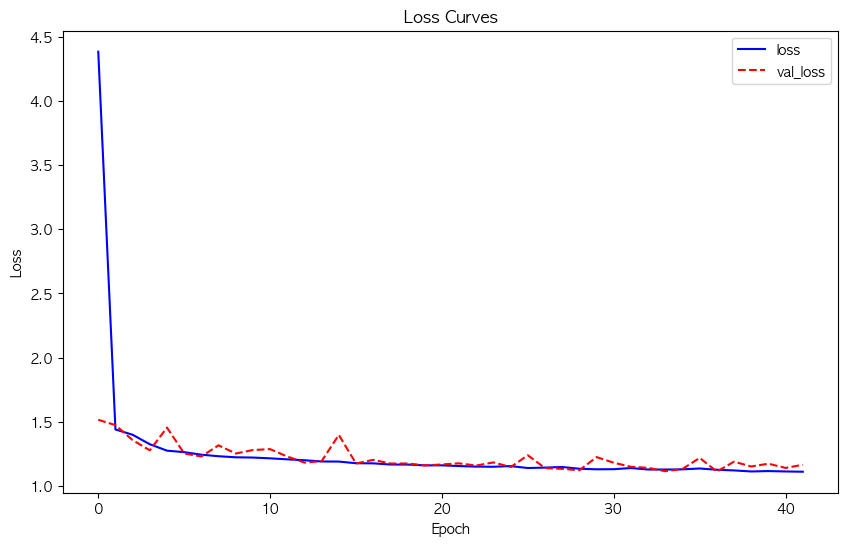

In [17]:
# 회귀 모델 학습 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [ ]:
keras_pred = keras_model.predict(X_test)

#### Sklearn model

In [ ]:
'''
param_grid = {
    'min_samples_leaf' : [4, 8],
    'min_samples_split' : [8, 16]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=20, n_estimators=600, max_depth=20), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
'''
# Best parameters: {'max_depth': 20, 'n_estimators': 600, 'min_samples_leaf': 8, 'min_samples_split': 8}

In [15]:
best_rf_model = RandomForestRegressor(random_state=20, max_depth=20, n_estimators=600, min_samples_leaf=8, min_samples_split=8)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=600, random_state=20)

In [16]:
# 테스트 데이터로 성능 평가
rf_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)
print(f"Test MSE: {mse}, Test MAE: {mae}")

Test MSE: 0.5667225491282746, Test MAE: 0.5045117941611854


#### Total predict graph

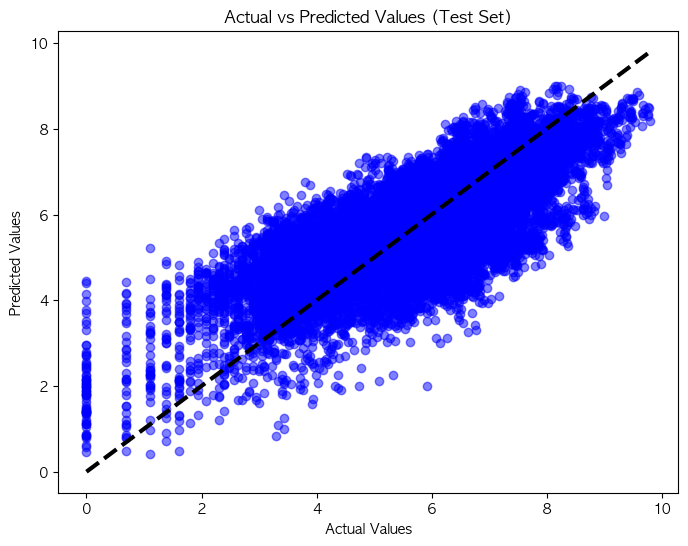

In [17]:
plt.figure(figsize=(8, 6))
#plt.scatter(y_test, keras_pred, alpha=0.5, c='red')
plt.scatter(y_test, rf_pred, alpha=0.5, c='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()